In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers tokenizers
!pip install pytorch_lightning==1.3.0

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
#The dataset used for the first finetuning step in this notebook was authored by Sharma et al. Full citation below.
_CITATION = """\
@inproceedings{sharma2020empathy,
    title={A Computational Approach to Understanding Empathy Expressed in Text-Based Mental Health Support},
    author={Sharma, Ashish and Miner, Adam S and Atkins, David C and Althoff, Tim},
    year={2020},
    booktitle={EMNLP}}
"""

In [ ]:
#we define the paths for train, val, test
train_path = "drive/MyDrive/empathy_classifier_data/train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/val.txt"

In [ ]:
#create a dictionary which associates each string label to an integer value
labels = [ "no", "weak", "strong"]
label2int = {"no": 0, "weak": 1, "strong": 2}

###Now we can start building a classifier

In [ ]:
#we use RoBERTa base

#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#load actual model
model = AutoModelWithLMHead.from_pretrained('roberta-base')
base_model = model.base_model

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:902: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
#now we need a custom classification head on top of the LM

#note: the following code is partly adapted from Marcin Zablocki's tutorial 'custom classifier on top of bert-like language model'

Use Mish activiation function as it's the one proposed in the original tutorial

In [ ]:
#using Mish activation function 
#(from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py)
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [ ]:
#define an EmpathyClassificationModel class to do the actual fine-tuning

class EmpathyClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
!mkdir -p tokenizer

In [ ]:
#load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [ ]:
#implementation of CollateFN to do tokenization and batches of sequences

class TokenizersCollateFn:
    def __init__(self, max_tokens=512): 

        #RoBERTa uses the BPE tokenizer, similarly to GPT-2
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
#class to create dataset objects from the data

class EmpathyDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
#sanity check, visualise one sample and label (converted to numerical)
ds = EmpathyDataset(train_path)
ds[20]

("We all are, and that's ok.", 1)

In [ ]:
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmpathyClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels))
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmpathyDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers=4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
    
    def save_model(self):
        torch.save(self.model.state_dict(), 'drive/MyDrive/t5_empathy/RoBERTa_empathy_finetuned.pt')

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=1.35E-05,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

In [ ]:
#save model (uncomment to save)
'''
module.save_model()
'''

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
              precision    recall  f1-score   support

          no     0.9792    0.8000    0.8806       235
        weak     0.8053    0.9681    0.8792       188
      strong     0.9749    1.0000    0.9873       194

    accuracy                         0.9141       617
   macro avg     0.9198    0.9227    0.9157       617
weighted avg     0.9248    0.9141    0.9137       617



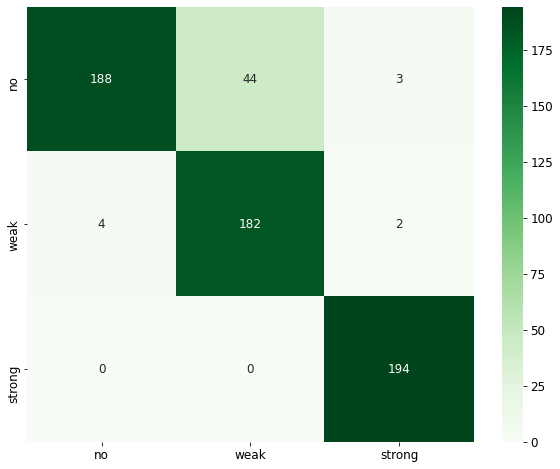

In [ ]:
#plot confusion matrix (since there are 77 classes this is quite a large matrix)

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');

## Fine tune on our data

In [ ]:
#we define the paths for train, val, test (change if desired to match location of splits created in baseline notebook)
train_path = "drive/MyDrive/empathy_classifier_data/my_train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/my_test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/my_val.txt"

In [ ]:
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmpathyDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW 
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), 'drive/MyDrive/t5_empathy/RoBERTa_empathy_twicefinetuned.pt')

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=20,
    lr=1.35E-05,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [ ]:
model = EmpathyClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels)) 
device = torch.device('cuda:0')
model.load_state_dict(torch.load('drive/MyDrive/t5_empathy/RoBERTa_empathy_finetuned.pt'))
model.to(device)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

In [ ]:
#save model (uncomment to save)
'''
module.save_model()
'''

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

\
________________________________________________________________________________
              precision    recall  f1-score   support

          no     0.8621    0.8065    0.8333        31
        weak     0.6383    0.7317    0.6818        41
      strong     0.8000    0.7179    0.7568        39

    accuracy                         0.7477       111
   macro avg     0.7668    0.7520    0.7573       111
weighted avg     0.7576    0.7477    0.7505       111



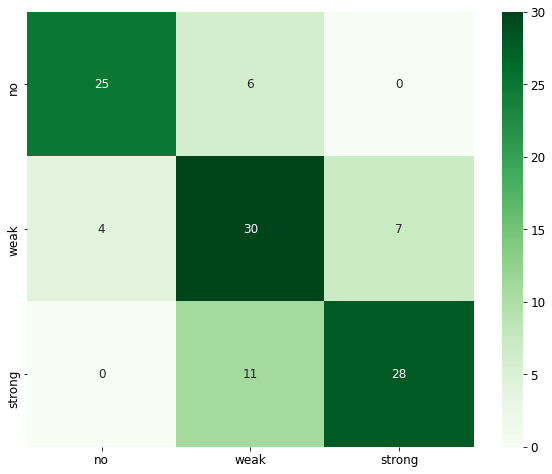

In [ ]:
#plot confusion matrix (since there are 77 classes this is quite a large matrix)

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');